---
title: Naive NerFs
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import optax
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
from dataclasses import dataclass


@dataclass
class FoxDM:
    _target_: str = "jejeqx._src.datamodules.image.ImageFox"
    batch_size: int = 10_000
    resize: int = 4
    shuffle: bool = False
    split_method: str = "even"
    
config_dm = OmegaConf.structured(FoxDM())

In [3]:
dm = hydra.utils.instantiate(config_dm)
dm.setup()


init = dm.ds_train[:32]
x_init, y_init = init

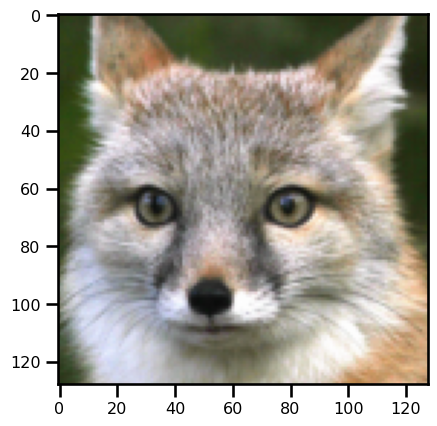

In [4]:
img = dm.load_image()
img.shape

plt.figure()
plt.imshow(img)
plt.show()

In [5]:
from dataclasses import dataclass
import hydra
from omegaconf import OmegaConf

In [6]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [7]:
# dm

In [8]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [9]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *swish* activation function.

$$
\sigma(\mathbf{x}) = \mathbf{x} \odot \text{Sigmoid}(\mathbf{x})
$$

In [10]:
from typing import Dict
from dataclasses import field


@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"

@dataclass
class IdentityAct:
    _target_: str = "equinox.nn.linear.Identity"
    
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123

@dataclass
class MLPModel:
    _target_: str = "equinox.nn.MLP"
    in_size: int = 2
    out_size: int = 3
    width_size: int = 128
    depth: int = 5
    activation: Activation = Activation()
    final_activation: IdentityAct = IdentityAct()
    key: Key = Key(seed=42)

In [11]:
# initialize model
model_config = OmegaConf.structured(MLPModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [12]:
@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 5e-3

In [13]:
optim_config = OmegaConf.structured(Optimizer())

optim = hydra.utils.instantiate(optim_config)

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).

In [14]:
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e-2
    warmup_steps: int = 500
    end_value: float = 1e-5
    
scheduler_config = OmegaConf.structured(Scheduler())

In [16]:
num_epochs = 3_000
num_steps_per_epoch = len(dm.ds_train)

scheduler = hydra.utils.instantiate(
    scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
)

In [17]:
optimizer = optax.chain(optim, optax.scale_by_schedule(scheduler))

## Trainer Module

In [18]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, y = batch
            out = jax.vmap(model)(x)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}

        return train_step, eval_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [19]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)


In [20]:
trainer.load_model("checkpoint_model_mlp.ckpt")

In [21]:
%%time

metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 3000 | Loss: 3.421e-03: 100%|███████| 3000/3000 [04:05<00:00, 12.23it/s]

CPU times: user 10min 22s, sys: 1min 9s, total: 11min 32s
Wall time: 4min 5s


In [22]:
trainer.save_model("checkpoint_model_mlp.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [23]:
out, metrics = trainer.predict_model(dm.predict_dataloader())
metrics

{'loss': 0.00355004876553744, 'psnr': 49.562626691576874}

In [24]:
out_img = dm.coordinates_2_image(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


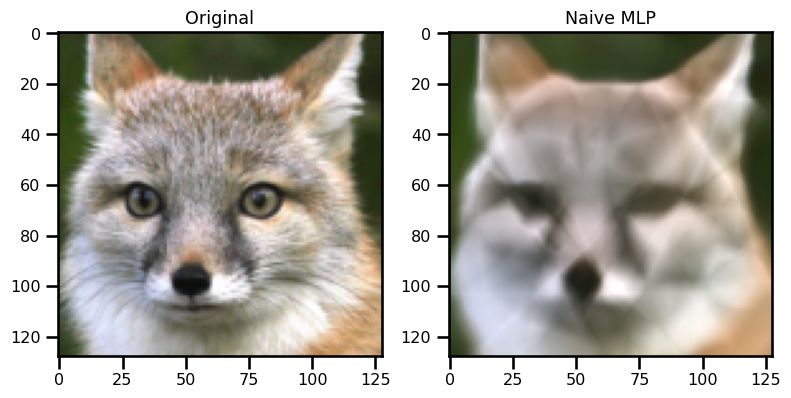

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].imshow(img)
ax[0].set(title="Original")
ax[1].imshow(out_img)
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

In [36]:
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123

@dataclass
class SirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
    in_size: int = 2
    out_size: int = 128
    width_size: int = 128
    depth: int = 5
    key: Key = Key()
    
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = 128
    out_features: int = 3
    use_bias: bool = True
    key: Key = Key()
    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    network: LinearModel = LinearModel()
    basis_net: SirenBasis = SirenBasis()

In [37]:
from jejeqx._src.nets.nerfs.base import NerF

In [38]:
# initialize model
model_config = OmegaConf.structured(NerFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

# assert out.shape == y_init.shape
# eqx.tree_pprint(model)
out.shape

(32, 3)

In [39]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

In [40]:
trainer.load_model("checkpoint_model_siren.ckpt")

In [41]:
%%time

metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 3000 | Loss: 5.548e-05: 100%|███████| 3000/3000 [06:25<00:00,  7.78it/s]

CPU times: user 16min 28s, sys: 1min 13s, total: 17min 41s
Wall time: 6min 25s


In [42]:
trainer.save_model("checkpoint_model_siren.ckpt")

In [43]:
out, metrics = trainer.predict_model(dm.predict_dataloader())
metrics

{'loss': 0.001141143550568697, 'psnr': 61.23921672276848}

In [44]:
out_siren = dm.coordinates_2_image(out)

In [45]:
out_img.min(), out_img.max(),

(0.050258338665585586, 1.0619732309160628)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


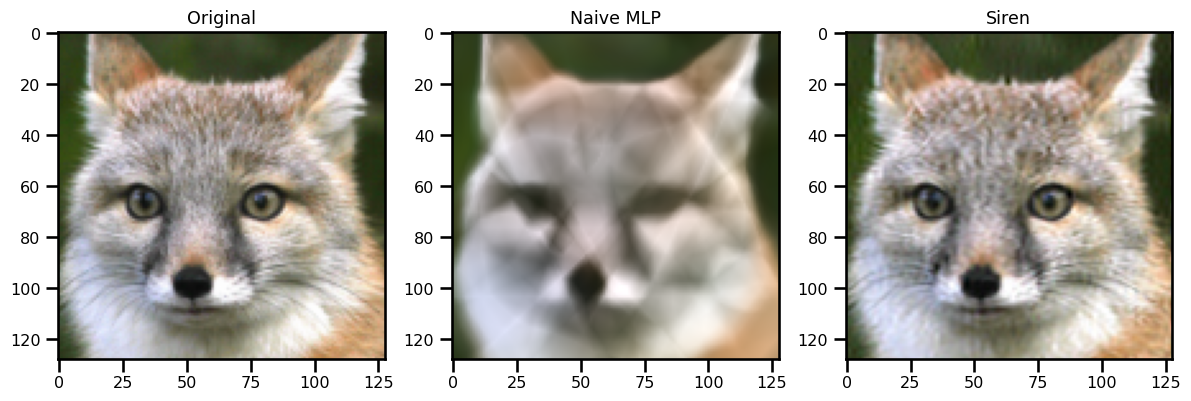

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].imshow(img)
ax[0].set(title="Original")
ax[1].imshow(out_img)
ax[1].set(title="Naive MLP")
ax[2].imshow(out_siren)
ax[2].set(title="Siren")

plt.tight_layout()
plt.show()